Retrieve calendar data

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import timedelta

# path to parent folder with subfolder for each of the 4 scrapes (retained structure from what Sakshi uploaded to Google drive)
path = 'C:/Users/Immig/Documents/DSBA-6211/Project_Airbnb/data/'

In [78]:
def filter_listings(df_c, min_nights, min_avail, scrape):
    
    unique = len(df_c['listing_id'].unique())
    print(f'{scrape}: Unique listings before filtering: {unique}')

    # remove all days where the minimum nights is more than min_nights
    df_c = df_c[df_c['minimum_nights'] <=min_nights]

    df_agg = df_c.groupby('listing_id', as_index=False).agg({
        'date': ['min', 'max', 'count'], 
        'available': 'mean',
        'price': 'mean',
        'minimum_nights':'mean',
        'maximum_nights':'mean'})
    
    df_agg.columns = ['listing_id', 'min_date', 'max_date', 'count_date', 'avg_avail', 'avg_price', 'avg_min_nights', 'avg_max_nights']
    df_agg['avg_booked'] = 1-df_agg['avg_avail']

    df_agg['days_avail'] = (df_agg['avg_avail']*df_agg['count_date']).astype('int')
    df_agg = df_agg[df_agg['days_avail'] >= min_avail]


    unique = len(df_agg)
    print(f'{scrape}: Unique listings after filtering: {unique}\n')

    df_filtered = df_c[df_c['listing_id'].isin(list(df_agg['listing_id']))]


    return df_filtered, df_agg

def fix_values(df_c):
    df_c['date'] = df_c['date'].astype('datetime64')
    df_c['price'] = df_c['price'].str.extract(pat='(\d*\.\d*)').round(decimals=2).astype('float64')
    df_c['adjusted_price'] = df_c['adjusted_price'].str.extract(pat='(\d*\.\d*)').round(decimals=2).astype('float64')
    df_c['available'] = df_c['available'].apply(lambda x: 1 if x=='t' else 0)

    return df_c

def get_calendar(days_after_scrape, min_nights, min_avail):
    print('Data to retain:')
    print(f'Time window each scrape\t\t\t\t{days_after_scrape} days: ')
    print(f'Maximum value allowed for minimum_nights\t{min_nights} nights')
    print(f'Minimum days available (each scrape)\t\t{min_avail} day(s)\n\n')


    df_c1 = pd.read_csv(path + '2021-12-17/calendar.csv')
    df_c1 = fix_values(df_c1)
    df_c1 = df_c1[df_c1['date']<=(df_c1['date'].min() + timedelta(days=days_after_scrape))]
    df_c1, _ = filter_listings(df_c1, min_nights, min_avail, 'Scrape 1')

    df_c2 = pd.read_csv(path + '2022-03-20/calendar.csv')
    df_c2 = fix_values(df_c2)
    df_c2 = df_c2[df_c2['date']<=(df_c2['date'].min() + timedelta(days=days_after_scrape))]
    df_c2, _ = filter_listings(df_c2, min_nights, min_avail, 'Scrape 2')

    df_c3 = pd.read_csv(path + '2022-06-13/calendar.csv')
    df_c3 = fix_values(df_c3)
    df_c3 = df_c3[df_c3['date']<=(df_c3['date'].min() + timedelta(days=days_after_scrape))]
    df_c3, _ = filter_listings(df_c3, min_nights, min_avail, 'Scrape 3')

    df_c4 = pd.read_csv(path +'2022-09-15/calendar.csv')
    df_c4 = fix_values(df_c4)
    df_c4 = df_c4[df_c4['date']<=(df_c4['date'].min() + timedelta(days=days_after_scrape))]
    df_c4, _ = filter_listings(df_c4, min_nights, min_avail, 'Scrape 4')

    df_calendar = pd.concat([df_c1, df_c2, df_c3, df_c4], axis=0)



    # if overlapping days_after_scrape, remove duplicates
    df_calendar.drop_duplicates(subset=['listing_id','date'],inplace=True,ignore_index=True,keep='last')


    _, df_agg = filter_listings(df_calendar, min_nights, min_avail, 'All scrapes')
    df_agg = df_agg.set_index(df_agg['listing_id']).drop(columns=['listing_id'])

    return df_calendar, df_agg

df_calendar, df_calendar_agg = get_calendar(60, 7, 1)

Data to retain:
Time window each scrape				60 days: 
Maximum value allowed for minimum_nights	7 nights
Minimum days available (each scrape)		1 day(s)


Scrape 1: Unique listings before filtering: 6358
Scrape 1: Unique listings after filtering: 4746

Scrape 2: Unique listings before filtering: 6798
Scrape 2: Unique listings after filtering: 5049

Scrape 3: Unique listings before filtering: 7242
Scrape 3: Unique listings after filtering: 5656

Scrape 4: Unique listings before filtering: 7732
Scrape 4: Unique listings after filtering: 6031

All scrapes: Unique listings before filtering: 7584
All scrapes: Unique listings after filtering: 7584



In [79]:
df_calendar_agg['avg_max_nights'] = df_calendar_agg['avg_max_nights'].apply(lambda x:
                    df_calendar_agg['avg_max_nights'].quantile(0.99) if x > df_calendar_agg['avg_max_nights'].quantile(0.99) else x)

In [80]:
# listings to keep and metrics for the time windows after each scrape
df_calendar_agg.head()

,min_date,max_date,count_date,avg_avail,avg_price,avg_min_nights,avg_max_nights,avg_booked,days_avail
listing_id,,,,,,,,,
39870,2021-12-17,2022-11-14,244,0.368852,66.790984,1.000000,851.000000,0.631148,90
72906,2021-12-17,2022-11-14,244,0.319672,102.237705,2.000000,1125.000000,0.680328,78
329997,2021-12-17,2022-11-14,243,0.251029,110.600823,2.185185,1032.983539,0.748971,61
395889,2021-12-17,2022-11-14,244,0.442623,92.192623,1.118852,6.000000,0.557377,108
421290,2021-12-17,2022-11-14,182,0.236264,104.307692,2.181319,1051.285714,0.763736,43


In [81]:
df_listings = pd.concat([pd.read_csv(path + '2021-12-17/listings.csv'),
                pd.read_csv(path + '2022-03-20/listings.csv'),
                pd.read_csv(path + '2022-06-13/listings.csv'),
                pd.read_csv(path + '2022-09-15/listings.csv')], axis = 0 , ignore_index=True)

df_listings.drop_duplicates(subset=['id'],inplace=True,ignore_index=True,keep='last')
len(df_listings)

9610

In [82]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9610 entries, 0 to 9609
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            9610 non-null   int64  
 1   listing_url                                   9610 non-null   object 
 2   scrape_id                                     9610 non-null   int64  
 3   last_scraped                                  9610 non-null   object 
 4   name                                          9609 non-null   object 
 5   description                                   9556 non-null   object 
 6   neighborhood_overview                         6474 non-null   object 
 7   picture_url                                   9610 non-null   object 
 8   host_id                                       9610 non-null   int64  
 9   host_url                                      9610 non-null   o

In [83]:
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,source
0,692017,https://www.airbnb.com/rooms/692017,20211217003604,2021-12-17,The Music City U.S.A Plantation,"Large house retreat with all amenities, movie ...",This small area within Nashville is best known...,https://a0.muscache.com/pictures/9231626/151f8...,3537810,https://www.airbnb.com/users/show/3537810,...,NaN,NaN,NaN,f,2,1,1,0,NaN,NaN
1,1039298,https://www.airbnb.com/rooms/1039298,20211217003604,2021-12-17,Hotel-quality Two-bedroom Suite,"If your Nashville visit is for only one night,...",Inglewood is a portion of hip East Nashville. ...,https://a0.muscache.com/pictures/c63359f4-0471...,5721539,https://www.airbnb.com/users/show/5721539,...,4.91,4.91,NaN,f,1,1,0,0,1.41,NaN
2,1130166,https://www.airbnb.com/rooms/1130166,20211217003604,2021-12-17,Private Suite in University Area,Permitted by Metro Nashville for Short Term Re...,"Our home is on a quiet street in the vibrant, ...",https://a0.muscache.com/pictures/71187326/39b2...,6201847,https://www.airbnb.com/users/show/6201847,...,4.99,4.98,NaN,f,1,1,0,0,3.96,NaN
3,1206512,https://www.airbnb.com/rooms/1206512,20211217003604,2021-12-17,Designer's Home in Belmont/12South,"Owned and renovated by an interior designer, t...",Seven minute walk to the heart of 12 South nei...,https://a0.muscache.com/pictures/18201511/410d...,3759875,https://www.airbnb.com/users/show/3759875,...,5.00,4.88,NaN,f,1,1,0,0,0.24,NaN
4,1844680,https://www.airbnb.com/rooms/1844680,20211217003604,2021-12-17,Private room in great location!,Bright yet cozy corner room in private home in...,"The house is situated on a quiet, leafy street...",https://a0.muscache.com/pictures/28381641/4e4f...,9637660,https://www.airbnb.com/users/show/9637660,...,4.78,4.90,NaN,t,2,0,2,0,1.73,NaN


In [84]:
# inital filtering based on calendar availability
df_listings = df_listings[df_listings['id'].isin(df_calendar_agg.index)]
len(df_listings)

7584

##### At least 1 review is required

In [85]:
df_listings = df_listings[~df_listings['first_review'].isnull()]
len(df_listings)

6867

In [86]:
# for listings with no reviews, add dummy values for first & last review 
#df_listings['first_review'] = df_listings['first_review'].fillna(value=pd.to_datetime('1/2/1989'))
#df_listings['last_review'] = df_listings['last_review'].fillna(value=pd.to_datetime('1/1/1989'))

df_listings['days_with_reviews'] = (pd.to_datetime(df_listings['last_review']) - pd.to_datetime(df_listings['first_review'])).dt.days

#print('Number of listings with 0 reviews:', len(df_listings[df_listings['days_with_reviews']==-1]))
print('Number of listings with 1 review:', len(df_listings[df_listings['days_with_reviews']==0]))

Number of listings with 1 review: 309


In [87]:
# a minimum number for 'days_with_reviews' is specified to penalize new listings without a "proven" track record
df_listings['days_with_reviews'] = df_listings['days_with_reviews'].apply(lambda x:180 if x < 180 else x)

# reviews per day is calculated using either the actual number of days between first & last review, OR the assigned minimum value of 180
df_listings['reviews_per_day'] = df_listings['number_of_reviews']/df_listings['days_with_reviews']

# remove listings with suspiciously many reviews
df_listings = df_listings[df_listings['reviews_per_day'] < 1]

Text(0.5, 1.0, 'after transformation')

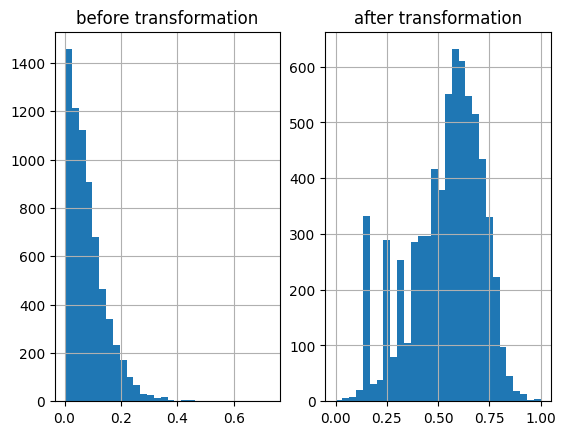

In [88]:
# log transform the reviews_per_day column
df_listings['review_freq_dv'] = np.log((df_listings['reviews_per_day']+0.001))
df_listings['review_freq_dv'] = (df_listings['review_freq_dv']-df_listings['review_freq_dv'].min())/(df_listings['review_freq_dv'].max()-df_listings['review_freq_dv'].min())
# df_listings['review_freq_dv'] = np.log((df_listings['reviews_per_day']+0.001)/(df_listings['reviews_per_day']+0.001).max())
len(df_listings)

plt.subplot(1, 2, 1)
df_listings['reviews_per_day'].hist(bins=30)
plt.title('before transformation')

plt.subplot(1, 2, 2)
df_listings['review_freq_dv'].hist(bins=30)
plt.title('after transformation')

In [89]:
df_calendar_agg

,min_date,max_date,count_date,avg_avail,avg_price,avg_min_nights,avg_max_nights,avg_booked,days_avail
listing_id,,,,,,,,,
39870,2021-12-17,2022-11-14,244,0.368852,66.790984,1.000000,851.000000,0.631148,90
72906,2021-12-17,2022-11-14,244,0.319672,102.237705,2.000000,1125.000000,0.680328,78
329997,2021-12-17,2022-11-14,243,0.251029,110.600823,2.185185,1032.983539,0.748971,61
395889,2021-12-17,2022-11-14,244,0.442623,92.192623,1.118852,6.000000,0.557377,108
421290,2021-12-17,2022-11-14,182,0.236264,104.307692,2.181319,1051.285714,0.763736,43
...,...,...,...,...,...,...,...,...,...
715789169240748205,2022-09-16,2022-11-14,60,0.966667,515.116667,1.183333,999.000000,0.033333,58
715789838753660311,2022-09-16,2022-11-14,60,0.966667,515.116667,1.183333,999.000000,0.033333,58
715793585554814480,2022-09-16,2022-11-14,60,0.933333,531.416667,1.183333,999.000000,0.066667,56


6863


Text(0.5, 1.0, 'after transformation')

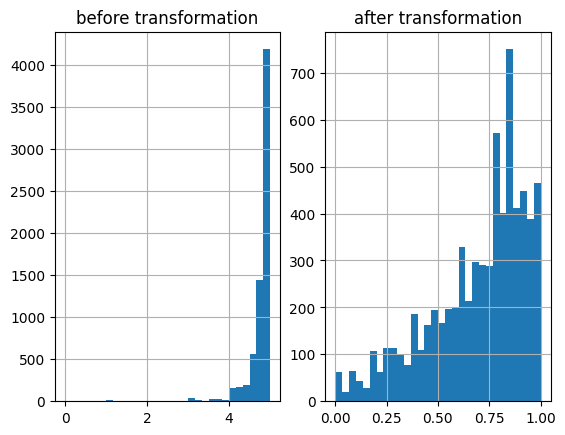

In [106]:
# Create df_combined
df_combined = df_listings.join(df_calendar_agg[['count_date', 'avg_price', 'avg_booked', 'avg_min_nights', 'avg_max_nights']], on='id', how='inner').reset_index(drop=True)
print(len(df_combined))

df_combined.head()

df_combined['review_scores_rating_adj'] = df_combined['review_scores_rating']
mean_review_score = df_combined['review_scores_rating'].mean()
col_ind = df_combined.shape[1]-1 # for changing a value with iloc

df_combined.iloc[0, col_ind]
# df_combined.head()


for i, rowdata in df_combined.iterrows():
    if df_combined['number_of_reviews'][i] <=1:
        df_combined.iloc[i, col_ind] = 0.5*mean_review_score + 0.5* df_combined['review_scores_rating'][i]
    elif df_combined['number_of_reviews'][i] <=8:
        df_combined.iloc[i, col_ind] = 0.3*mean_review_score + 0.7* df_combined['review_scores_rating'][i]
    elif df_combined['number_of_reviews'][i] <=15:
        df_combined.iloc[i, col_ind] = 0.1*mean_review_score + 0.9* df_combined['review_scores_rating'][i]
    else:
        df_combined.iloc[i, col_ind] = df_combined['review_scores_rating'][i]


# transform the review score distribution by exponetiation
df_combined['review_scores_dv'] = np.power(10,df_combined['review_scores_rating_adj'])
df_combined['review_scores_dv'] = df_combined['review_scores_dv']/df_combined['review_scores_dv'].max()


plt.subplot(1, 2, 1)
df_combined['review_scores_rating'].hist(bins=30)
plt.title('before transformation')

plt.subplot(1, 2, 2)
df_combined['review_scores_dv'].hist(bins=30)
plt.title('after transformation')

Text(0, 0.5, 'days with reviews')

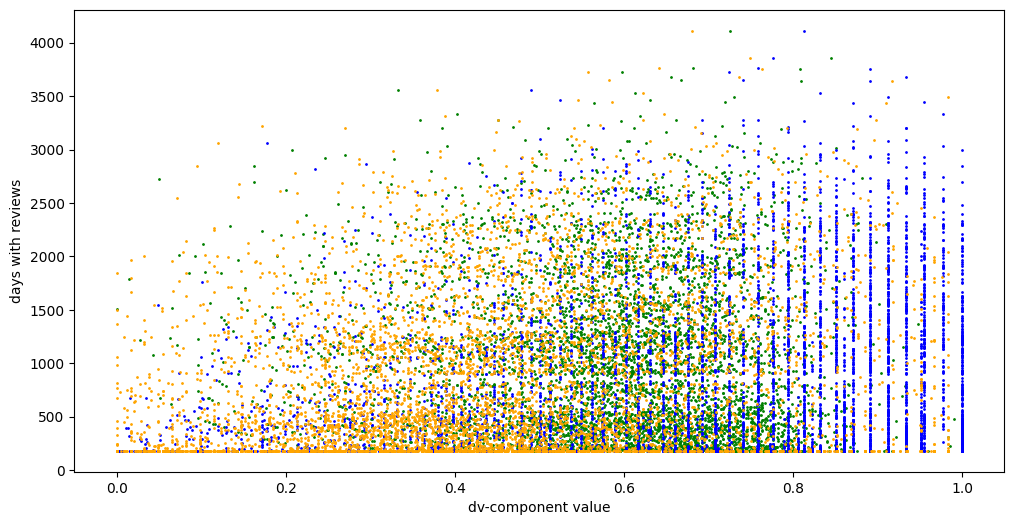

In [107]:
fig = plt.figure(figsize=(12,6))

plt.scatter(df_combined['review_freq_dv'], df_combined['days_with_reviews'], 1, c='green')
plt.scatter(df_combined['review_scores_dv'], df_combined['days_with_reviews'], 1, c='blue')
plt.scatter(df_combined['avg_booked'], df_combined['days_with_reviews'], 1, c='orange')
plt.xlabel('dv-component value')
plt.ylabel('days with reviews')

In [108]:
df_combined[['review_freq_dv', 'review_scores_dv', 'avg_booked']].describe()

,review_freq_dv,review_scores_dv,avg_booked
count,6863.000000,6863.000000,6863.000000
mean,0.536261,0.694321,0.442365
std,0.174475,0.237590,0.217868
min,0.000000,0.002458,0.000000
25%,0.428499,0.549541,0.290984
50%,0.567255,0.772904,0.432099
75%,0.665192,0.859759,0.590164
max,1.000000,1.000000,0.983607


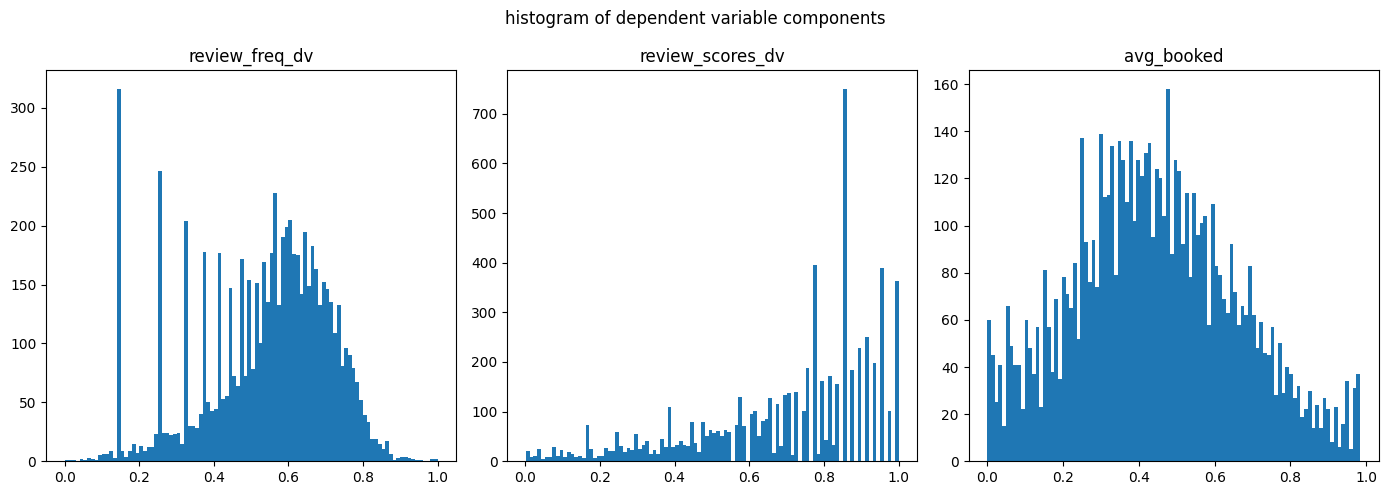

In [109]:
fig, ax = plt.subplots(1, 3, figsize=(14,5), sharey=False)
fig.suptitle('histogram of dependent variable components')
ax[0].set_title('review_freq_dv')
ax[0].hist(df_combined['review_freq_dv'],bins=100)
ax[1].set_title('review_scores_dv')
ax[1].hist(df_combined['review_scores_dv'],bins=100)
ax[2].set_title('avg_booked')
ax[2].hist(df_combined['avg_booked'],bins=100)

fig.tight_layout()


<AxesSubplot: >

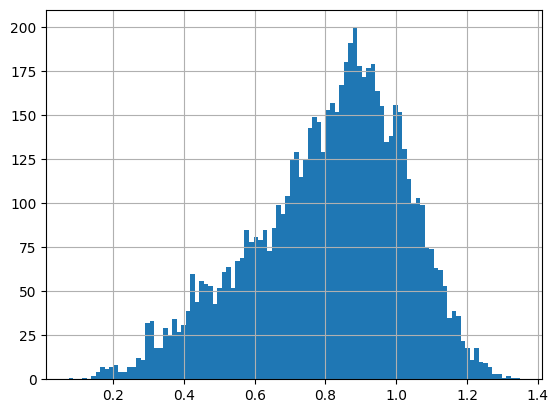

In [110]:
wght_review_freq= 1
wght_review_score = 0.2
wght_bookings = 0.3

df_combined['dep_candidate'] = wght_review_freq*df_combined['review_freq_dv'] + wght_review_score * df_combined['review_scores_dv'] + wght_bookings * df_combined['avg_booked']
df_combined['dep_candidate'].hist(bins=100)

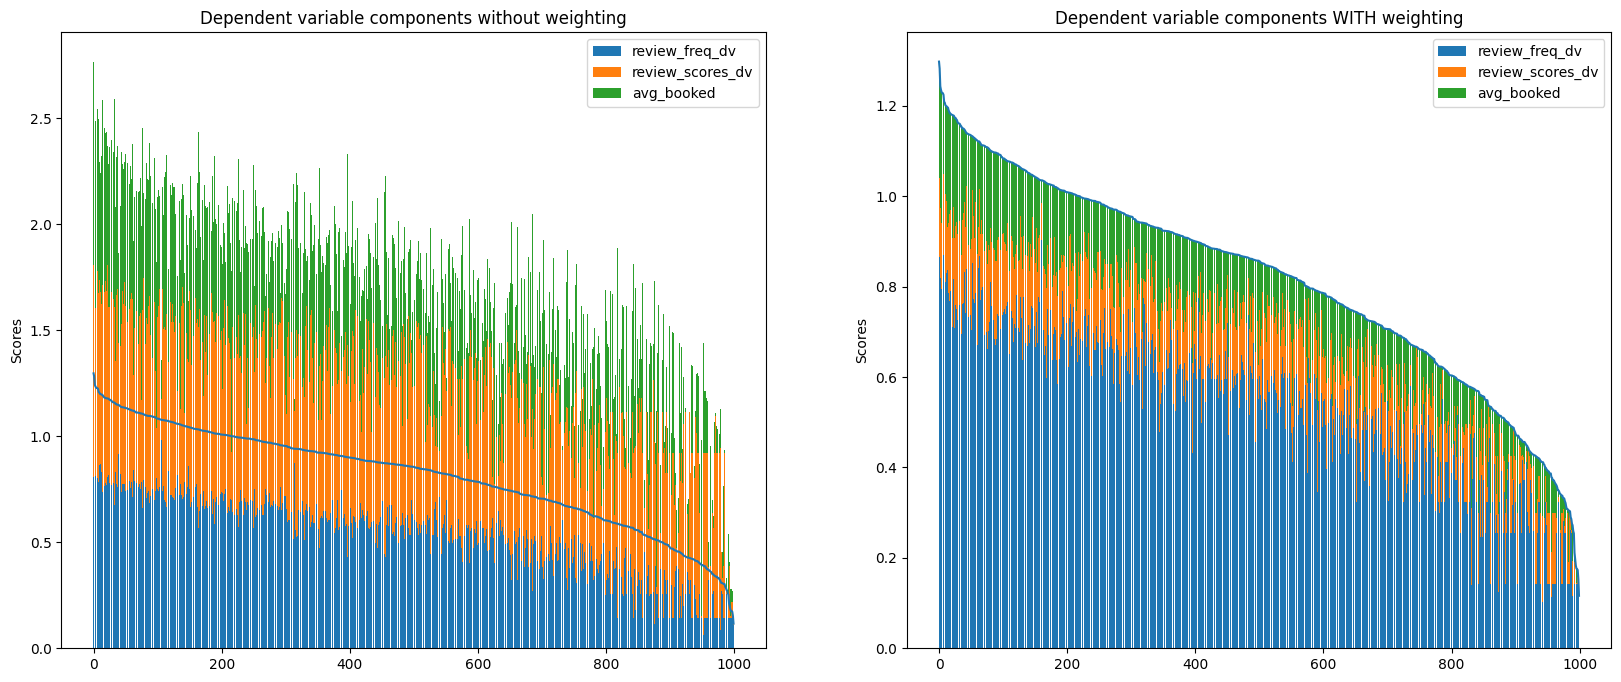

In [111]:
alpha = 1
sample = df_combined.sample(n=1000)
sample = sample.sort_values('dep_candidate', ascending=False)
sample = sample.reset_index()

fig, ax = plt.subplots(1, 2, figsize=(20,8))
labels = [val for val in sample.index]

ax[0].plot(labels, sample['dep_candidate'])
ax[0].bar(labels, sample['review_freq_dv'], label='review_freq_dv', alpha=alpha)
ax[0].bar(labels, sample['review_scores_dv'], bottom=sample['review_freq_dv'], label='review_scores_dv', alpha=alpha)
ax[0].bar(labels, sample['avg_booked'], bottom=sample['review_scores_dv']+sample['review_freq_dv'], label='avg_booked', alpha=alpha)

ax[0].set_ylabel('Scores')
ax[0].set_title('Dependent variable components without weighting')
ax[0].legend()

ax[1].plot(labels, sample['dep_candidate'])
ax[1].bar(labels, wght_review_freq*sample['review_freq_dv'], label='review_freq_dv', alpha=alpha)
ax[1].bar(labels, wght_review_score*sample['review_scores_dv'], bottom=wght_review_freq*sample['review_freq_dv'], label='review_scores_dv', alpha=alpha)
ax[1].bar(labels, wght_bookings*sample['avg_booked'], bottom=wght_review_score*sample['review_scores_dv']+wght_review_freq*sample['review_freq_dv'], label='avg_booked', alpha=alpha)

ax[1].set_ylabel('Scores')
ax[1].set_title('Dependent variable components WITH weighting')
ax[1].legend()

In [112]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6863 entries, 0 to 6862
Data columns (total 86 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6863 non-null   int64  
 1   listing_url                                   6863 non-null   object 
 2   scrape_id                                     6863 non-null   int64  
 3   last_scraped                                  6863 non-null   object 
 4   name                                          6863 non-null   object 
 5   description                                   6850 non-null   object 
 6   neighborhood_overview                         4913 non-null   object 
 7   picture_url                                   6863 non-null   object 
 8   host_id                                       6863 non-null   int64  
 9   host_url                                      6863 non-null   o

In [114]:
droplist1 = ['neighbourhood_group_cleansed', 'bathrooms', 'calendar_updated', 'license'] # all nulls
droplist2 = ['source'] # not useful
droplist3 = ['days_with_reviews', 'reviews_per_day', 'review_freq_dv', 
            'count_date', 'avg_booked', 'review_scores_rating_adj', 'review_scores_dv'] # columns used to create "dep_candidate"
droplist4 = ["minimum_nights", "maximum_nights", "minimum_minimum_nights", "maximum_minimum_nights",
            "minimum_maximum_nights", "maximum_maximum_nights", "minimum_nights_avg_ntm",
            "maximum_nights_avg_ntm"]

droplist = droplist1 + droplist2 + droplist3 + droplist4
df_combined.drop(columns=droplist, inplace=True)

In [115]:
df_combined.to_parquet('_df_for_modeling.parquet')